In [1]:
%%javascript
utils.load_extension("execute_time/ExecuteTime")
utils.load_extension('collapsible_headings/main') 

<IPython.core.display.Javascript object>

In [2]:
# Import candidate models
from doubt import Boot, QuantileRegressor, QuantileRegressionForest
from sklearn.linear_model import (LinearRegression, PoissonRegressor, 
                                  GammaRegressor, HuberRegressor)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

# Import datasets
from doubt.datasets import (Airfoil, Blog, Concrete, CPU, 
                            FacebookComments, FishBioconcentration,
                            FishToxicity, ForestFire, NewTaipeiHousing,
                            PowerPlant, Protein, Servo,
                            SpaceShuttle, Yacht)

# Import external libraries
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from scipy.stats import ks_2samp, entropy, kruskal
import matplotlib.pyplot as plt; plt.style.use('ggplot')

import warnings
from collections import defaultdict
%matplotlib inline
from matplotlib import rcParams
plt.style.use('seaborn-whitegrid')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['figure.figsize'] = 16,8

# Import internal classes
from distributions import DistributionShift
from tqdm.notebook import tqdm

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

In [4]:
from xgboost import XGBRegressor
from tabulate import tabulate

import shap

In [5]:
dataset_classes = [
    Airfoil,
    #Concrete,
    #FishToxicity,
    #ForestFire,
    #NewTaipeiHousing,
    #PowerPlant,
    #Protein,
    #Servo,
]

In [6]:
for dataset in dataset_classes:
    print(dataset().shape)

(1503, 6)


In [7]:
def initialise_plot(
    num_rows: int, num_cols: int, base_regressor: type, dataset
):
    fig, axs = plt.subplots(
        num_rows,
        num_cols,
        sharex=True,
        sharey=True,
        figsize=(14, 3.5 * num_rows),
    )
    plt.legend()
    fig.suptitle(
        f"Monitoring plot for the {dataset.__name__} dataset under feature drift with {base_regressor.__name__}",
        fontsize=16,
    )
    for j in range(num_cols):
        axs[num_rows - 1, j].set_xlabel("Sorted columnd index")
    for i in range(num_rows):
        axs[i, 0].set_ylabel("Normalised values")
    return fig, axs

In [8]:
def kol_smi(x):
    return ks_2samp(x, BASE_COMP).statistic
def psi_stat(x):
    return psi(x, BASE_COMP)

In [11]:
def monitoring_plot(dataset, base_regressor: type, n_boots: int = 20, **kwargs):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Initialise the scaler
        standard_scaler = StandardScaler()

        # Load the dataset and split it
        X, _, y, _ = dataset().split(test_size=0.001, random_seed=4242)

        # Scale the dataset
        X = standard_scaler.fit_transform(X)

        # Back to dataframe
        X = pd.DataFrame(X, columns=["Var %d" % (i + 1) for i in range(X.shape[1])])
        data = X.copy()
        data["target"] = y

        # Train test splitting points
        fracc = 0.33
        oneThird = int(data.shape[0] * fracc)
        twoThird = data.shape[0] - int(data.shape[0] * fracc)
        print(
            "Number of rows {}, 1split {}, 2nd split {}".format(
                data.shape[0], oneThird, twoThird
            )
        )

        # Initialize plots
        num_rows = X.shape[1] // 3
        if X.shape[1] % 3 > 0:
            num_rows += 1
        fig, axs = initialise_plot(
            num_rows=num_rows,
            num_cols=3,
            base_regressor=base_regressor,
            dataset=dataset,
        )

        shap_res = []

        for idx, col in tqdm(enumerate(X.columns), total=len(X.columns)):
            values = defaultdict(list)

            # Sort data on the column
            data = data.sort_values(col).reset_index(drop=True).copy()

            # Train Test Split
            data_sub = data.iloc[:oneThird]
            data_train = data.iloc[oneThird:twoThird]
            data_up = data.iloc[twoThird:]

            X_tot = data.drop(columns="target")
            X_tr = data_train.drop(columns="target")
            X_sub = data_sub.drop(columns="target")
            X_up = data_up.drop(columns="target")

            y_tot = data[["target"]].target.values
            y_tr = data_train[["target"]].target.values
            y_sub = data_sub[["target"]].target.values
            y_up = data_up[["target"]].target.values

            # Fit the regressor
            regressor = base_regressor()
            regressor.fit(X_tr, y_tr)

            # Predictions
            preds = regressor.predict(X_tot)
            preds_tr = cross_val_predict(
                estimator=regressor,
                X=X_tr,
                y=y_tr,
                cv=KFold(n_splits=5, shuffle=True, random_state=0),
            )

            # explain the model's predictions using SHAP
            explainer = shap.Explainer(regressor)
            shap_values = explainer(X_tot)
            shap_values = pd.DataFrame(data=shap_values.values, columns=X_tot.columns)
            
            shap_values_train = explainer(X_tr)
            shap_values_train = pd.DataFrame(data=shap_values_train.values, columns=X_tot.columns)
            
            # Model from explained data
            ex = base_regressor()
            error_tr = np.abs(preds_tr-y_tr)
            ex.fit(X_tr,error_tr)
            expl = ex.predict(shap_values)

            # pred_up, interval_up = regressor.predict(X_up, uncertainty=0.05, n_boots=n_boots)
            # pred_tr, interval_tr = regressor.predict(X_tr, uncertainty=0.05, n_boots=n_boots)
            # print("Sub:", np.round(mean_absolute_error(y_sub, pred_sub), decimals=2))
            # print("train:", np.round(mean_absolute_error(y_tr, pred_tr), decimals=2))
            # print("up:", np.round(mean_absolute_error(y_up, pred_up), decimals=2))
            # print("total:", np.round(mean_absolute_error(y_tot, preds), decimals=2))

            # print("Sub Uncertainty:", np.round(np.mean(interval_sub[:, 1] - interval_sub[:, 0]), decimals=2))
            # print("tr Uncertainty:", np.round(np.mean(interval_tr[:, 1] - interval_tr[:, 0]), decimals=2))
            # print("Up Uncertainty:", np.round(np.mean(interval_up[:, 1] - interval_up[:, 0]), decimals=2))
            # print("Total Uncertainty:", np.round(np.mean(intervals[:, 1] - intervals[:, 0]), decimals=2))

            # Statistics
            df = pd.DataFrame(np.abs(preds - y_tot), columns=["error"])
            df["mean_shap"] = np.mean(np.abs(shap_values), axis=1)
            df['explanations'] = expl

            error_raw = df["error"].values

            ROLLING_STAT = 100
            ### KS Test
            df["ks"] = data[col]
            global BASE_COMP
            BASE_COMP = data[col]
            df[["ks"]] = (
                df[["ks"]].rolling(ROLLING_STAT, int(ROLLING_STAT * 0.5)).apply(kol_smi)
            )  # Takes ages

            ### Shap col Test
            df["shap_col"] = shap_values[col]
            BASE_COMP = shap_values_train[col]
            df[["shap_col"]] = (
                df[["shap_col"]]
                .rolling(ROLLING_STAT, int(ROLLING_STAT * 0.5))
                .apply(kol_smi)
            )  # Takes ages

            ### Rolling window on all
            # df = df.rolling(ROLLING_STAT, int(ROLLING_STAT * 0.5)).mean().dropna()

            ## Scaling
            # df = df.dropna()
            # df = pd.DataFrame(standard_scaler.fit_transform(df), columns=df.columns)

            # Convert to dic for plotting
            for index, col in enumerate(df.columns):
                values[col] = df[col]

            # uncertainty_res.append(mean_absolute_error(values["error"], values["uncertainty"]))
            # ks_res.append(mean_absolute_error(values["error"], values["ks"]))
            # psi_res.append(mean_absolute_error(values["error"], values["PSI"]))

            # Plotting
            for name, vals in values.items():
                if idx == 0:
                    axs[idx // 3, idx % 3].plot(vals, label=f"{name} values")
                else:
                    axs[idx // 3, idx % 3].plot(vals, label=f"{name} values")


            plt.figure()
            plt.title("Error raw")
            plt.plot(error_raw)
            plt.show()

            plt.figure()
            plt.title("Error rolling window")
            plt.plot(df["error"].values)
            plt.xlabel("Sorted column index ")
            plt.ylabel("Absolute Error")
            plt.show()

            plt.figure()
            plt.title("Mean absolute shap value per row (RW)")
            plt.plot(df["mean_shap"].values, color="blue")
            plt.xlabel("Sorted column index ")
            plt.ylabel("Shap value contribution (absolute value)")
            plt.show()

            plt.figure()
            plt.title("Shap values between  (RW)")
            plt.plot(df["mean_shap"].values, color="blue", label="Partial Train")
            plt.plot(df["error"].values, color="red", label="Model Performance")
            plt.legend()
            plt.show()

            plt.figure()
            plt.title("ShapKS, KS and Model Performance")
            plt.plot(df["ks"], label="KS")
            plt.plot(df["shap_col"], label="ShapKS")
            # plt.plot(df["mean_shap"].values,color='blue',label='Partial Train')
            # plt.plot(df["mean_shap_full"].values,color='k',label='Full Train')
            sc = StandardScaler()
            plt.plot(sc.fit_transform(df.rolling(50).mean()["error"].values.reshape(-1, 1)), label="Model Performance")
            print('KS:',np.sum(np.abs(df['error']-df['ks'])))
            print('Shap:',np.sum(np.abs(df['error']-df['shap_col'])))
            print('Explanations:',np.sum(np.abs(df['error']-df['explanations'])))
            plt.legend()
            plt.show()
            
            plt.figure()
            plt.title("ShapKS, KS, Model Performance and SHAP performance")
            plt.plot(df["ks"], label="KS")
            plt.plot(df["shap_col"], label="ShapKS")
            # plt.plot(df["mean_shap"].values,color='blue',label='Partial Train')
            # plt.plot(df["mean_shap_full"].values,color='k',label='Full Train')
            sc = StandardScaler()
            plt.plot(sc.fit_transform(df.rolling(50).mean()["error"].values.reshape(-1, 1)), label="Model Performance")
            plt.plot(sc.fit_transform(df.rolling(50).mean()["explanations"].values.reshape(-1, 1)), label="Explanations Prediction")
            plt.legend()
            plt.show()

        resultados = pd.DataFrame({"shap_res": shap_res})
        media = resultados.mean()
        std = resultados.std()
        resultados.loc["mean"] = media
        resultados.loc["std"] = std

        print(resultados.to_string())

        fig.legend()
        # plt.savefig("fig.png")
        plt.show()

No handles with labels found to put in legend.


Number of rows 1501, 1split 495, 2nd split 1006


  0%|          | 0/5 [00:00<?, ?it/s]

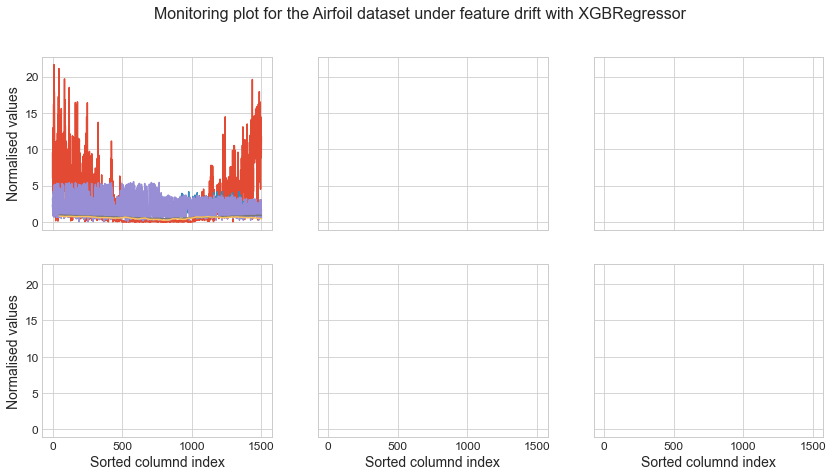

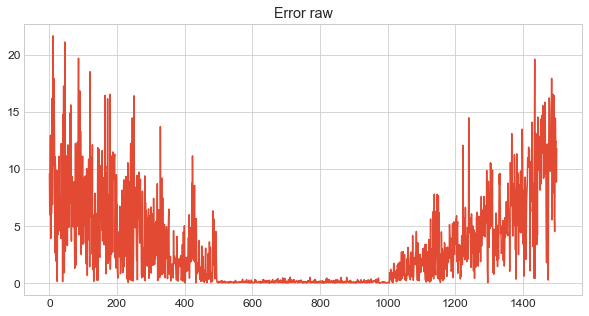

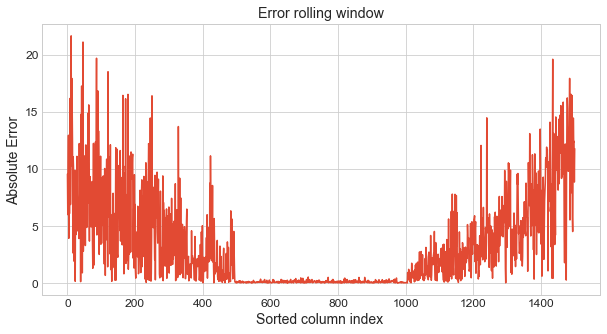

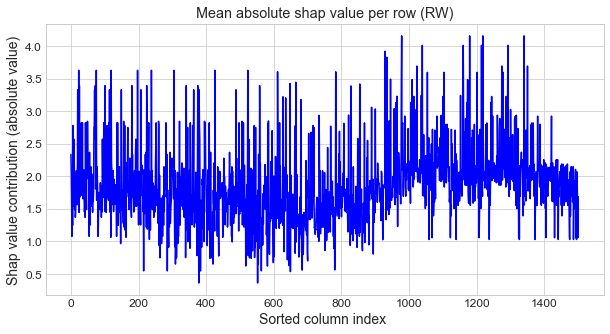

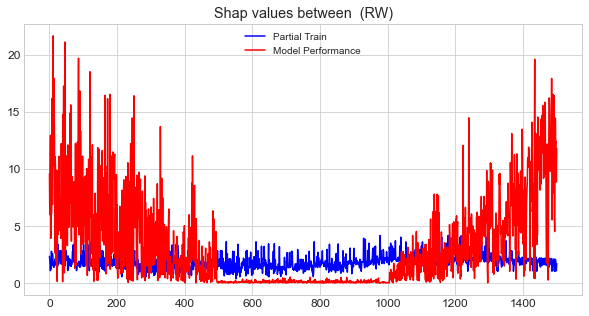

KS: 3925.706827375515
Shap: 3975.2044417588068
Explanations: 4573.049530445546


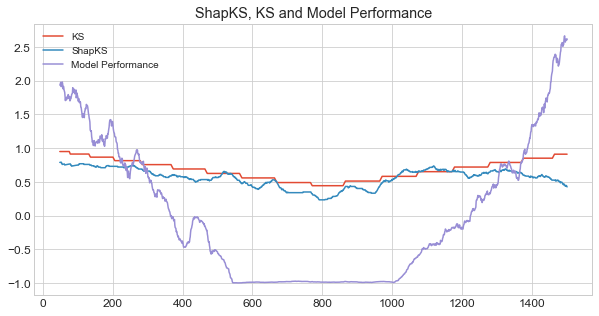

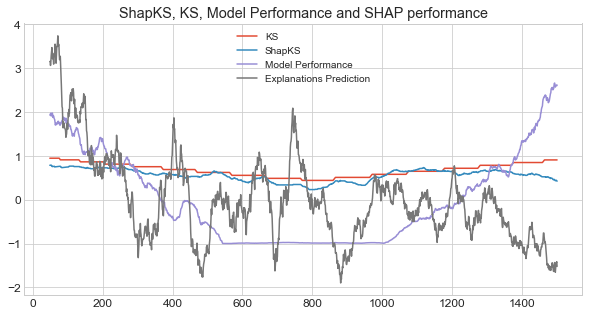

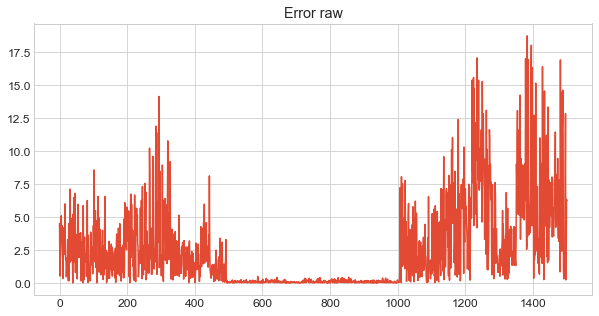

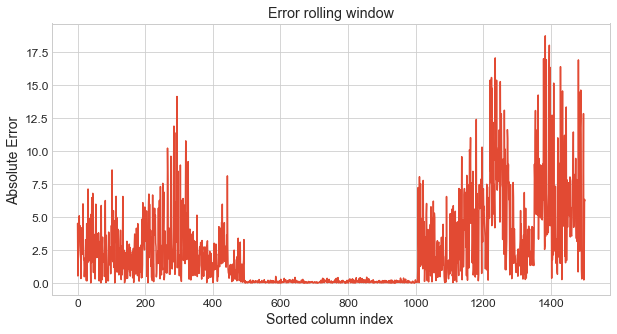

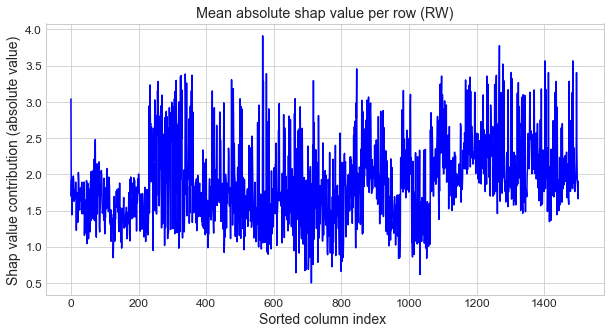

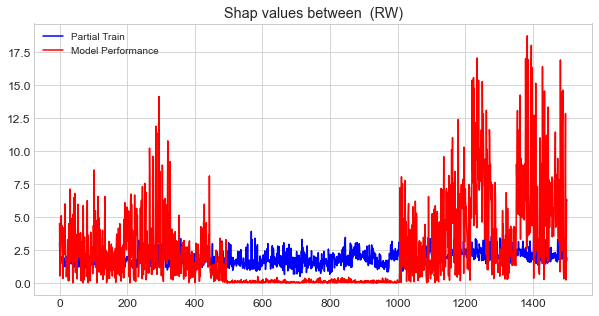

KS: 3103.9642080070403
Shap: 3175.7839660334726
Explanations: 3479.2571221485828


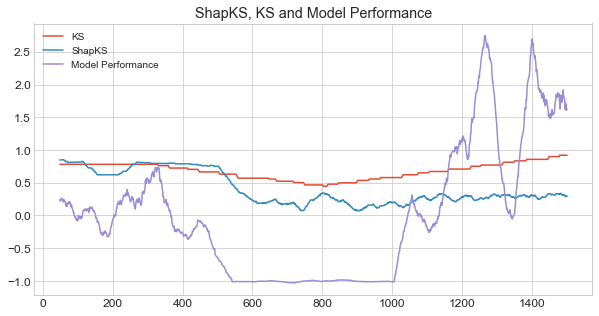

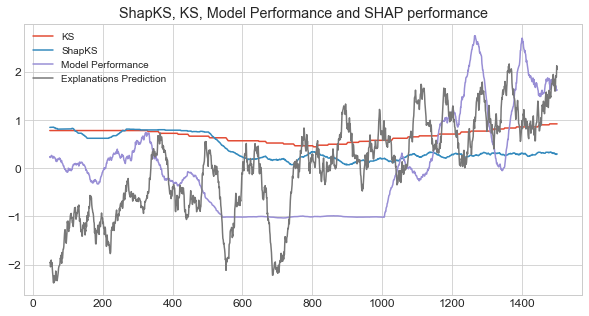

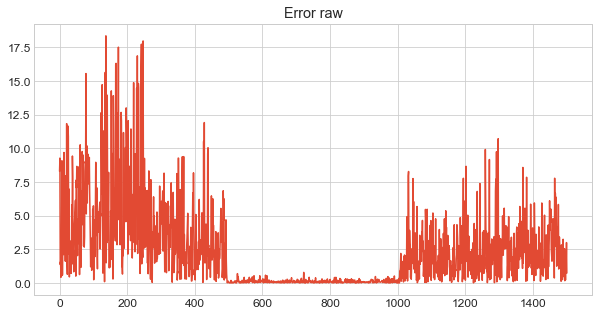

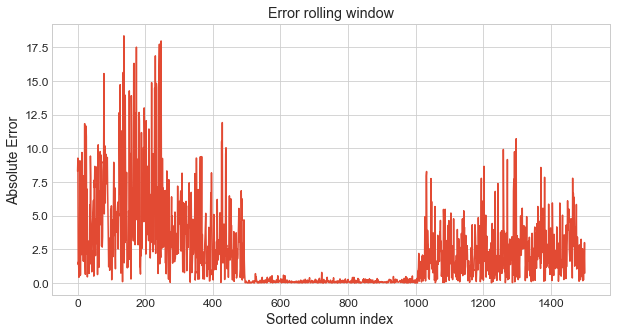

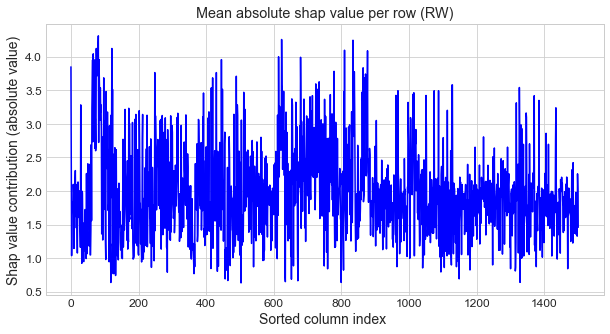

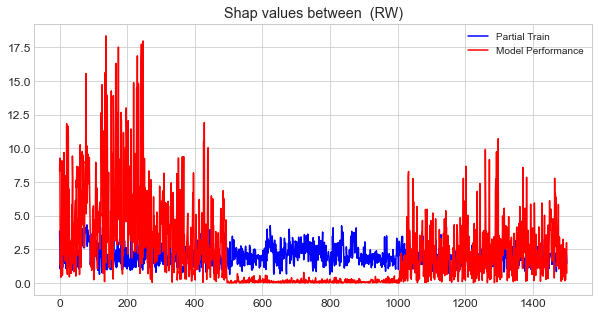

KS: 2846.486916545179
Shap: 3092.680637529639
Explanations: 4547.786826999858


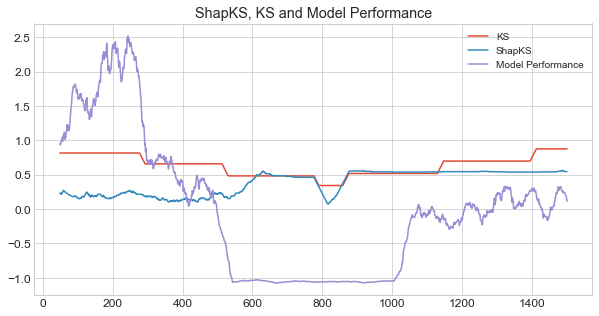

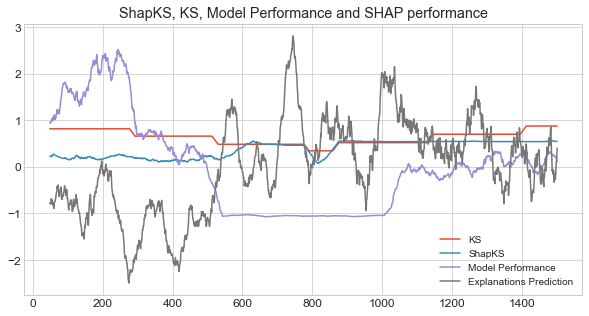

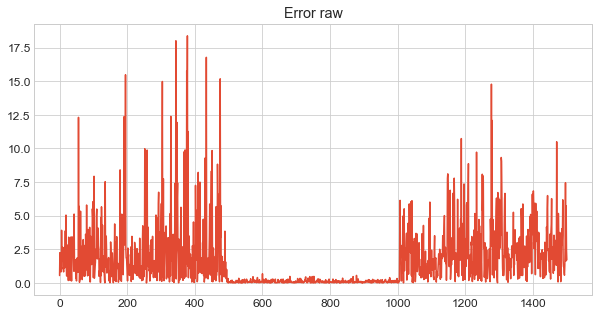

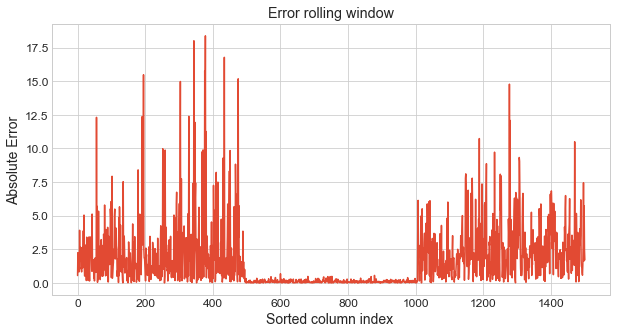

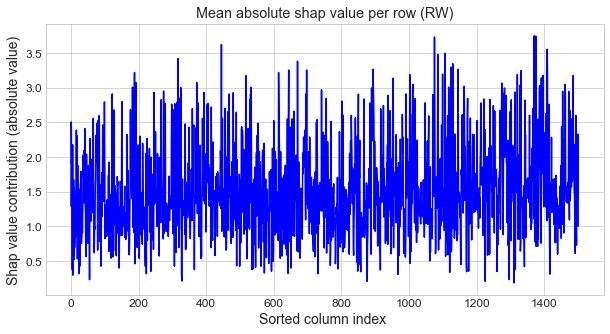

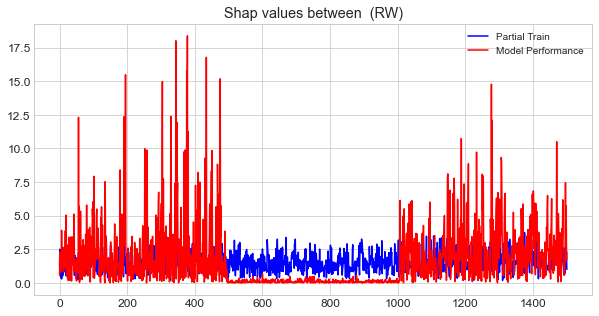

KS: 1998.8491609767075
Shap: 2081.043407449976
Explanations: 2844.2943007518948


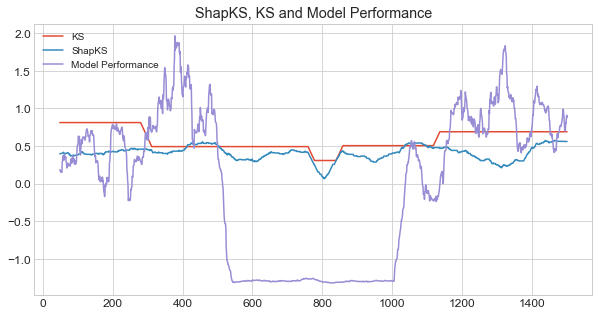

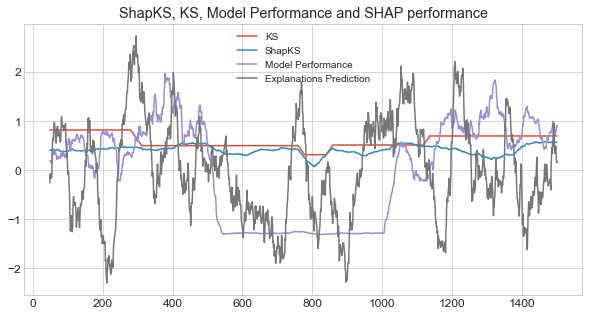

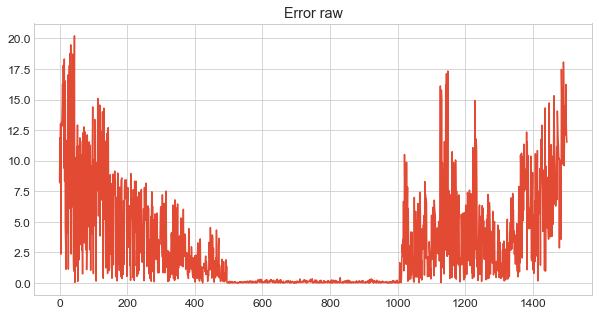

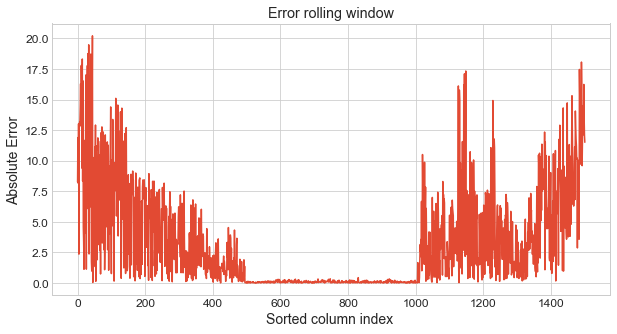

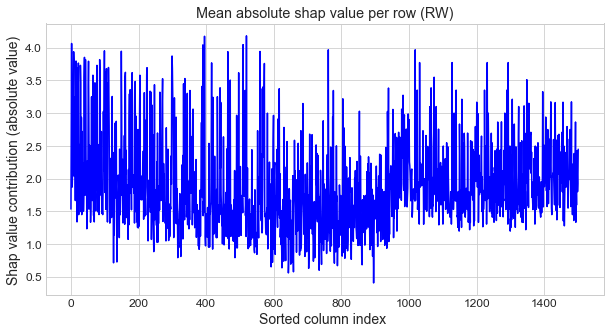

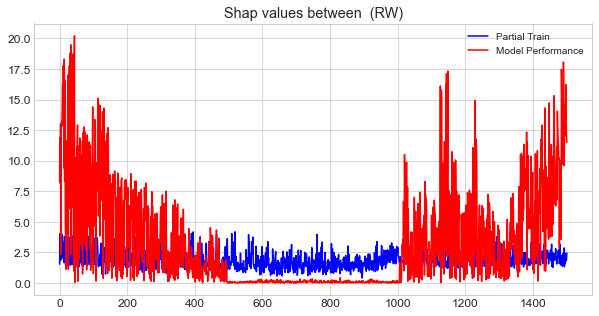

KS: 3886.721442986983
Shap: 3976.668755962548
Explanations: 4834.356053398837


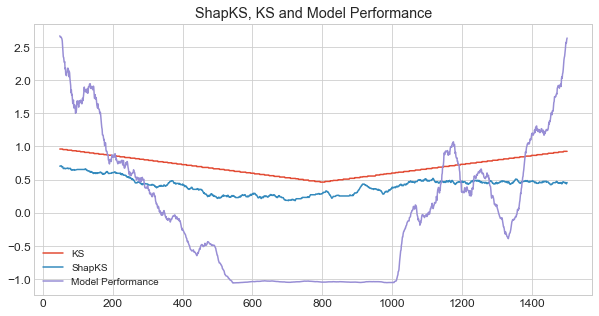

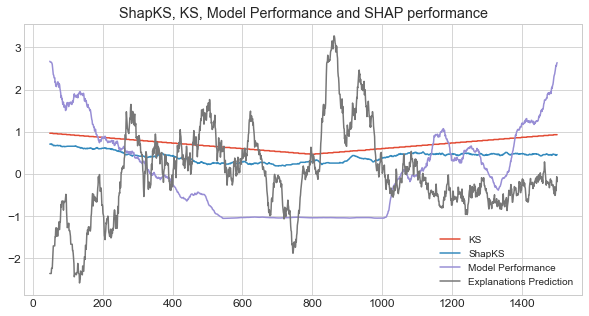

      shap_res
mean       NaN
std        NaN


In [12]:
for dataset in dataset_classes:
     a = monitoring_plot(dataset, XGBRegressor)

In [13]:
kk

NameError: name 'kk' is not defined

TypeError: 'NoneType' object is not subscriptable

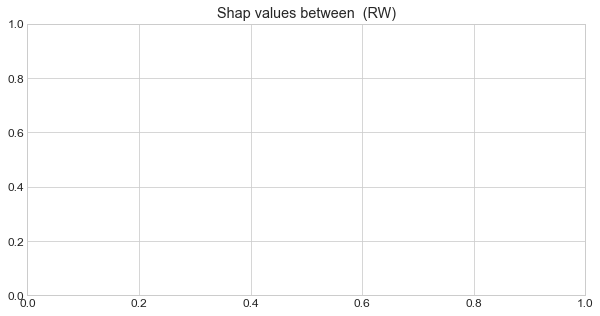

In [12]:
df = a
plt.figure()
plt.title("Shap values between  (RW)")
plt.plot(df["ks"], label="KS")
plt.plot(df["shap_col"], label="ShapKS")

sc = StandardScaler()
plt.plot(sc.fit_transform(df.rolling(50).mean()["error"].values.reshape(-1, 1)), label="Model Performance")
plt.legend()
plt.show()

In [ ]:
for dataset in dataset_classes:
    monitoring_plot(dataset, DecisionTreeRegressor,max_depth=20)
    #monitoring_plot(dataset,RandomForestRegressor)



In [ ]:
for dataset in dataset_classes:
    monitoring_plot(dataset,RandomForestRegressor,n_estimators = 20)



In [ ]:
for dataset in dataset_classes:
    monitoring_plot(dataset,XGBRegressor)



In [ ]:
for dataset in dataset_classes:
    monitoring_plot(dataset,MLPRegressor)



Q:

More explanation types?
    Can we compare with this method to argumentation methods?
More data types?
    Saliency maps on images

